In [1]:
"""
ctg_cleaning.py
----------------
Preprocesses the CTG dataset for model training.
Performs:
- Missing value removal
- Column cleanup
- Saves cleaned dataset as CSV

Usage:
    python data_exploration/ctg_cleaning.py
"""

# =============================
# Imports
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# =============================
# Load Dataset
# =============================
print("[INFO] Loading CTG dataset...")
df = pd.read_excel("CTG.xls", sheet_name="Raw Data")

# =============================
# Basic Cleaning
# =============================
print("[INFO] Cleaning dataset...")

# Remove empty rows and footer metadata
df = df.dropna(how="all")
df = df.drop(columns=[
    "FileName", "Date", "SegFile", "LBE", "A", "B", "C", "D", "E",
    "AD", "DE", "LD", "FS", "SUSP", "CLASS"
])
df = df.drop([2128, 2129], errors="ignore")  # remove non-data rows

# Adjust label values
df["NSP"] -= 1  # Convert {1,2,3} → {0,1,2}
df = df.drop_duplicates()

# =============================
# Feature Transformations
# =============================
print("[INFO] Applying transformations...")

# =============================
# Save Cleaned Dataset
# =============================
output_path = "CTG_cleaned.csv"
df.to_csv(output_path, index=False)
print(f"[SUCCESS] Cleaned dataset saved to: {output_path}")
print(f"[INFO] Final shape: {df.shape}")
print(f"[INFO] Columns: {list(df.columns)}")

[INFO] Loading CTG dataset...
[INFO] Cleaning dataset...
[INFO] Applying transformations...
[SUCCESS] Cleaned dataset saved to: CTG_cleaned.csv
[INFO] Final shape: (2115, 25)
[INFO] Columns: ['b', 'e', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'DR', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency', 'NSP']


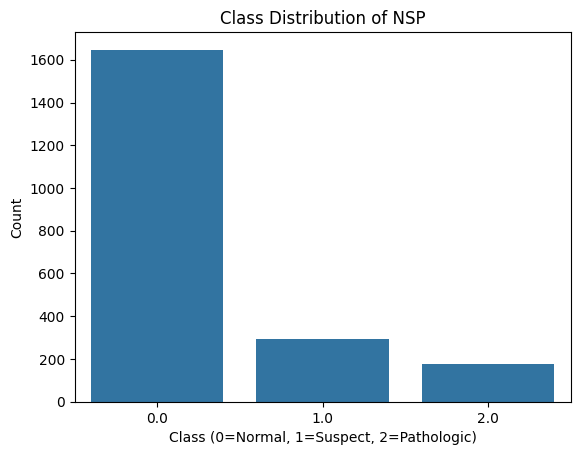

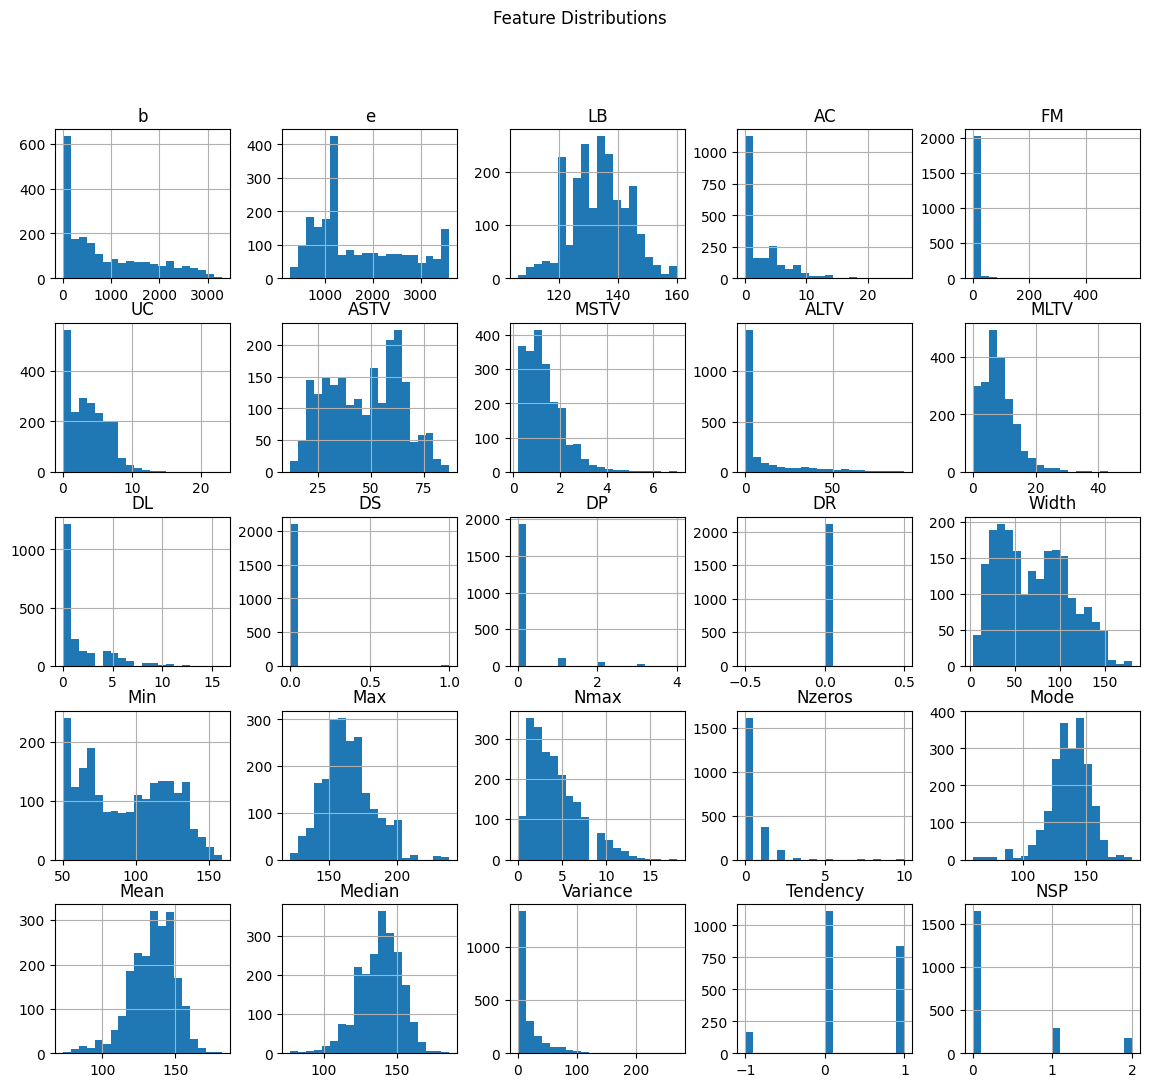


ANOVA Test Results:

Top 5 Most Significant Features:
      f_statistic        p_value  significant
DP     541.740521  1.220388e-190         True
ASTV   339.428830  1.505828e-128         True
ALTV   337.442186  6.778937e-128         True
Mean   299.311090  3.596849e-115         True
Mode   276.822638  1.696230e-107         True

Least Significant Features:
        f_statistic   p_value  significant
Nmax      11.968598  0.000007         True
FM         5.040502  0.006549         True
Max        2.577426  0.076208        False
Nzeros     2.174192  0.113954        False
DR              NaN       NaN        False


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


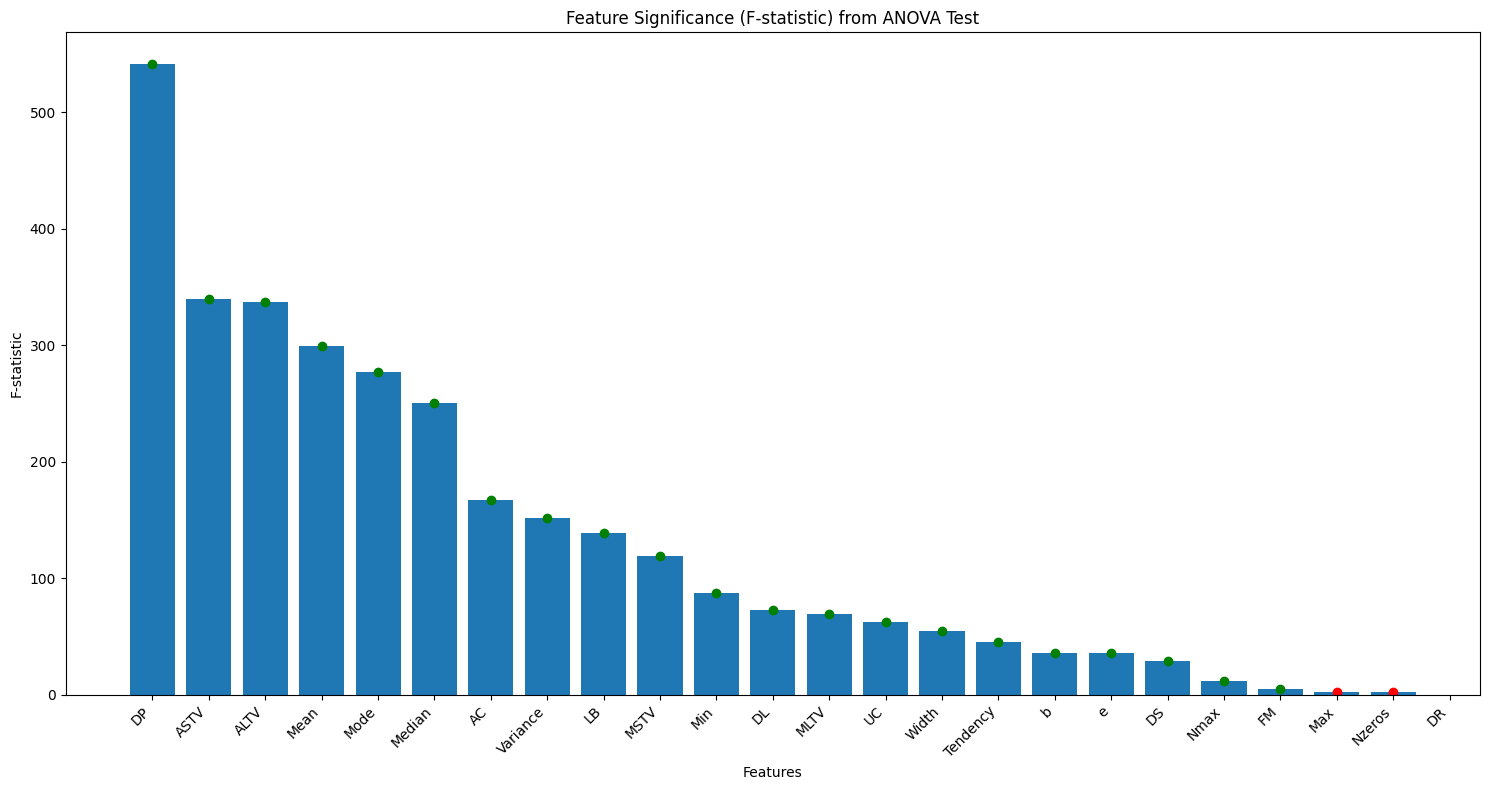

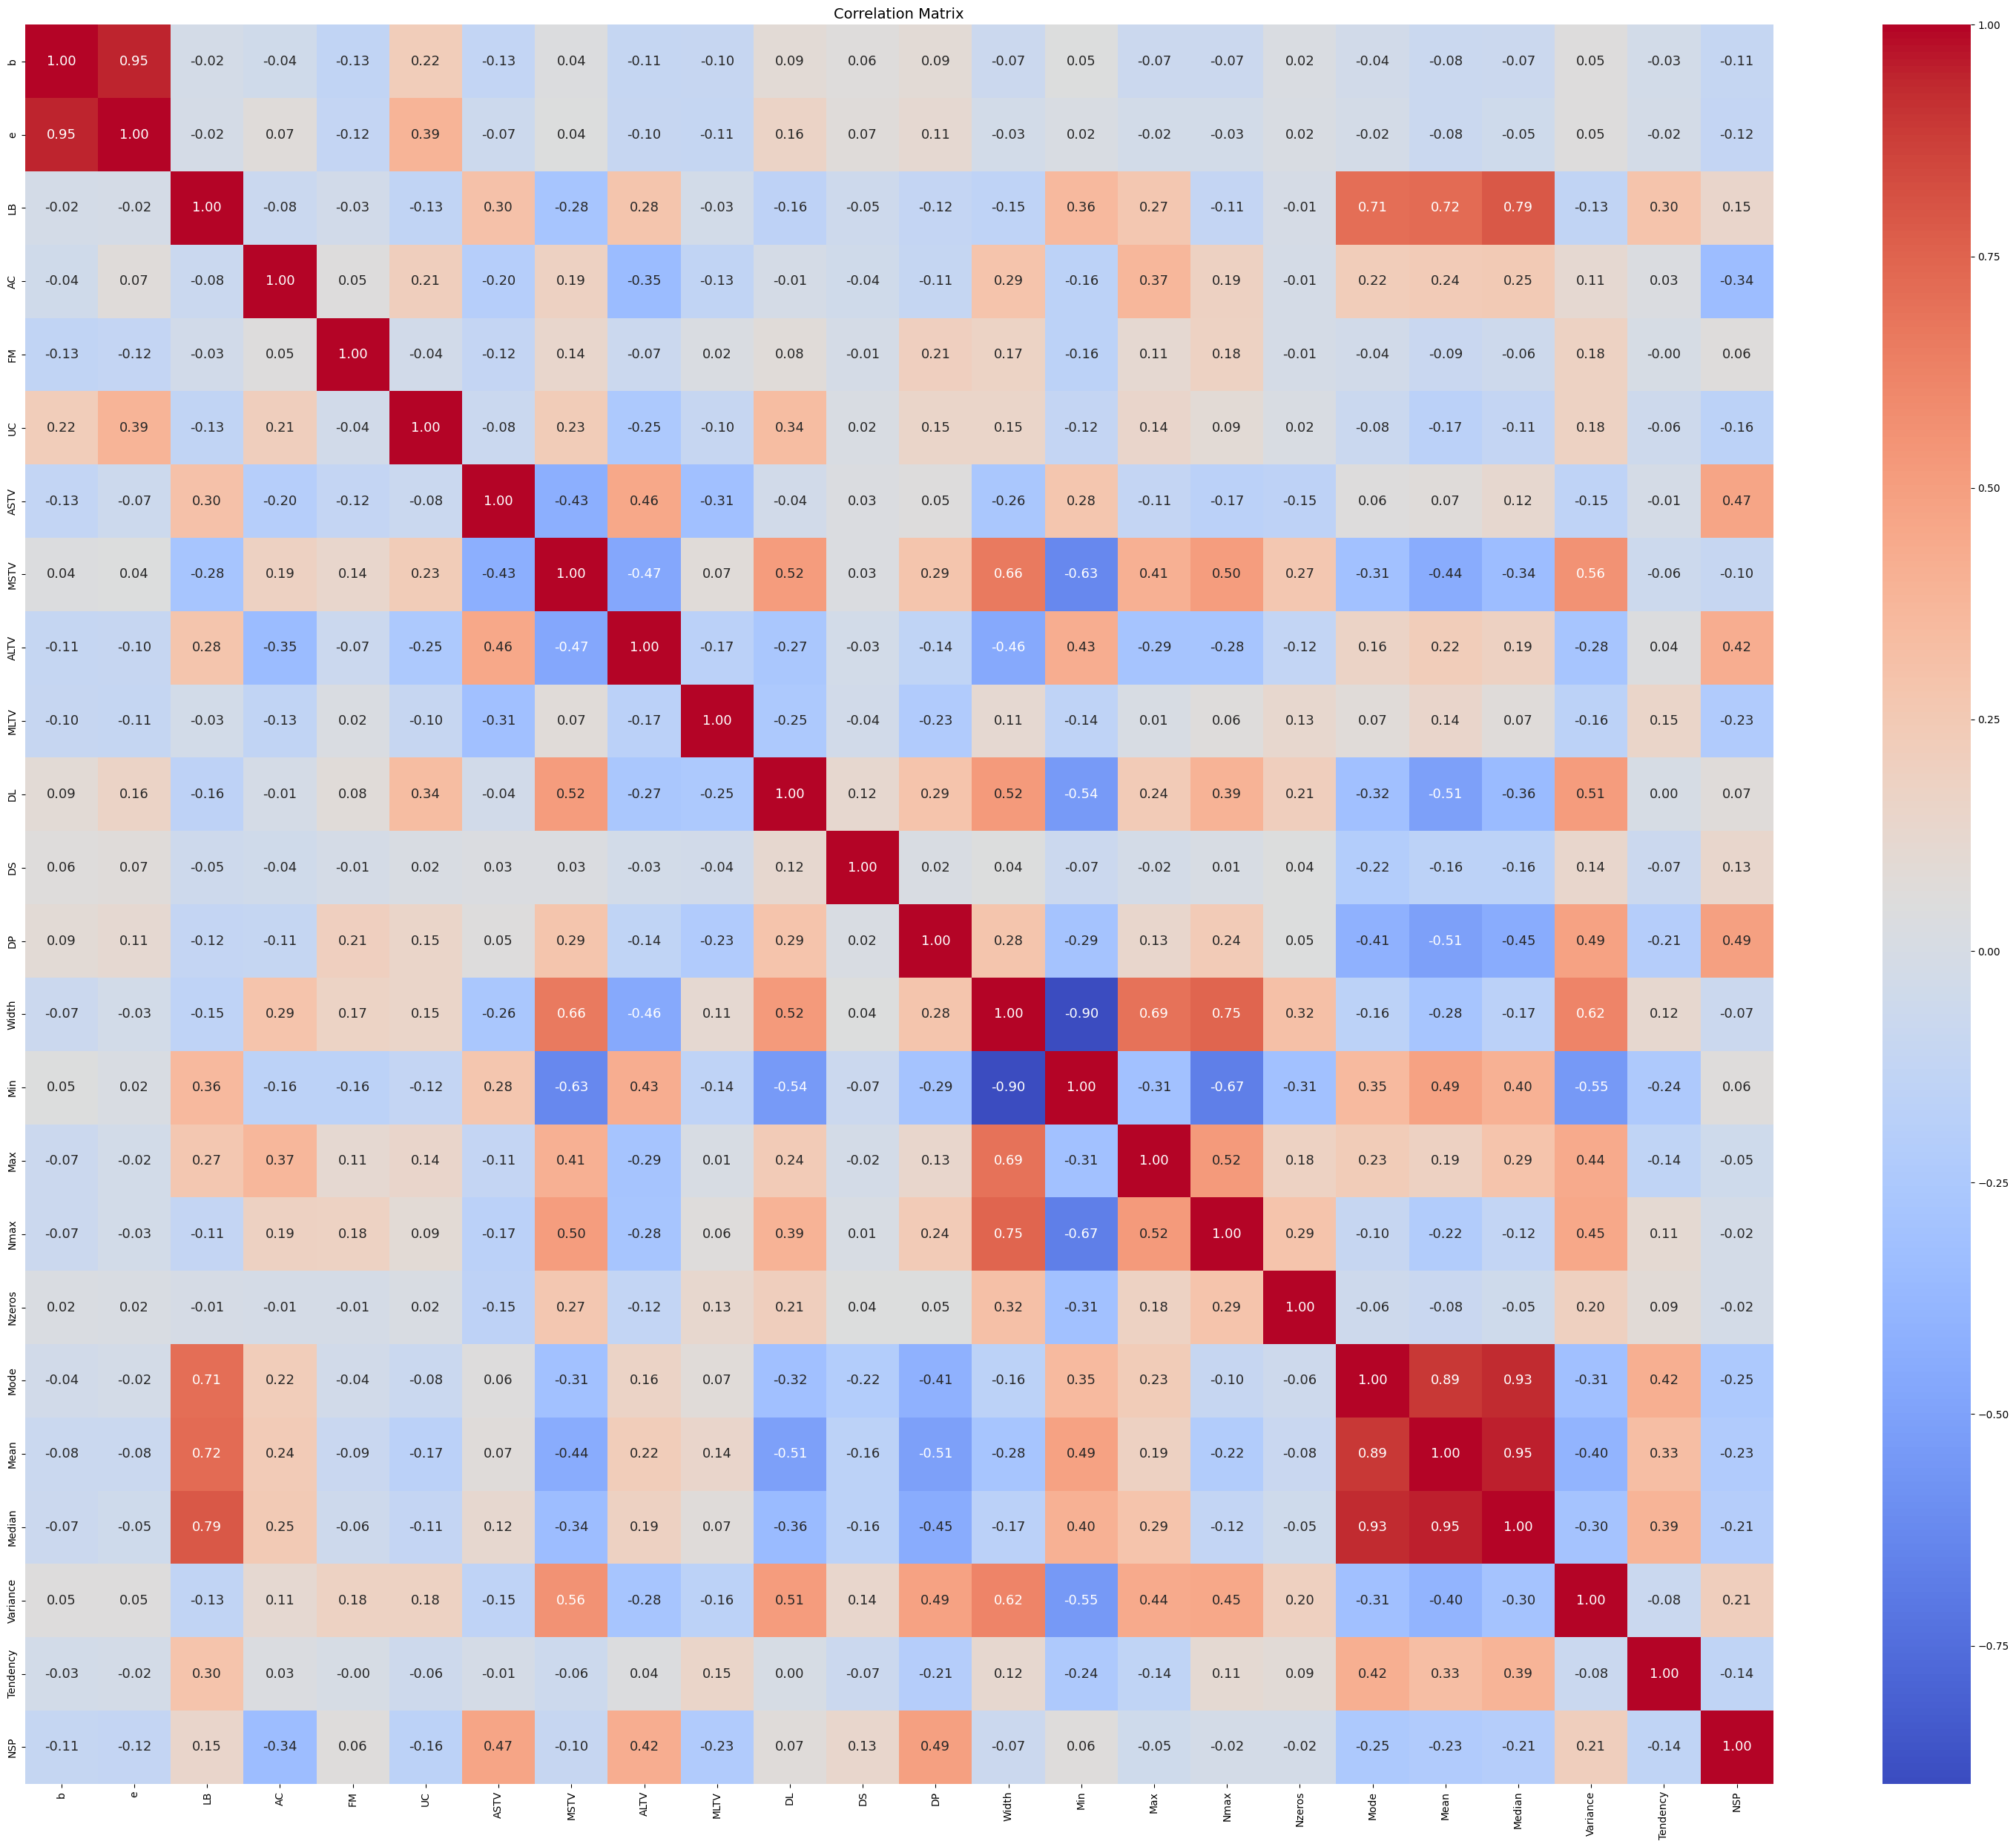

In [2]:
sns.countplot(x="NSP", data=df)
plt.title("Class Distribution of NSP")
plt.xlabel("Class (0=Normal, 1=Suspect, 2=Pathologic)")
plt.ylabel("Count")
plt.show()

df.hist(figsize=(14,12), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

def perform_anova_analysis(df):

    anova_results = {}

    for feature in df.columns[:-1]: 
        classes = [
            group[feature].values 
            for name, group in df.groupby('NSP')
        ]

        f_statistic, p_value = stats.f_oneway(*classes)

        anova_results[feature] = {
            'f_statistic': f_statistic,
            'p_value': p_value
        }

    results_df = pd.DataFrame(anova_results).T
    results_df['significant'] = results_df['p_value'] < 0.05

    results_df = results_df.sort_values('f_statistic', ascending=False)
    
    return results_df

def plot_anova_results(results_df):
    
    plt.figure(figsize=(15, 8))
    plt.bar(range(len(results_df)), results_df['f_statistic'])
    plt.xticks(range(len(results_df)), results_df.index, rotation=45, ha='right')
    plt.title('Feature Significance (F-statistic) from ANOVA Test')
    plt.xlabel('Features')
    plt.ylabel('F-statistic')

    for i, significant in enumerate(results_df['significant']):
        color = 'green' if significant else 'red'
        plt.plot(i, results_df['f_statistic'].iloc[i], 'o', color=color)
    
    plt.tight_layout()
    
    return plt

results = perform_anova_analysis(df)

print("\nANOVA Test Results:")
print("\nTop 5 Most Significant Features:")
print(results.head())
print("\nLeast Significant Features:")
print(results.tail())
plot_anova_results(results)
plt.show()


df=df.drop(columns=['DR'])
correlation_matrix = df.corr()
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, annot_kws={'size': 13})
plt.title('Correlation Matrix', fontsize=14)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Reasons for dropping each feature

b, e, Tendency: No relevance to NSP state biologically

Median, Mode: 2 extra features describing central histogram features

Max, DS, DR, Nzeroes: Negligible correlation to the other values as shown in correlation matrix and ANOVA analysis

In [3]:
df=df.drop(columns=['b', 'e', 'Median', 'Mode', 'Max','DS', 'Nzeros', 'Tendency'])

In [5]:
df.head()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DP,Width,Min,Nmax,Mean,Variance,NSP
1,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,64.0,62.0,2.0,137.0,73.0,1.0
2,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,130.0,68.0,6.0,136.0,12.0,0.0
3,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,130.0,68.0,5.0,135.0,13.0,0.0
4,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,117.0,53.0,11.0,134.0,13.0,0.0
5,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,117.0,53.0,9.0,136.0,11.0,0.0
